In [1]:
!pip install tensorflow==2.10.0

  Obtaining dependency information for tensorflow==2.10.0 from https://files.pythonhosted.org/packages/04/ea/49fd026ac36fdd79bf072294b139170aefc118e487ccb39af019946797e9/tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for keras<2.11,>=2.10.0 from https://files.pythonhosted.org/packages/f9/4d/dc255a437c9616b155e5bd55e325e092b7cdcb4652361d733ae051d40853/keras-2.10.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for keras-preprocessing>=1.1.1 from https://files.pythonhosted.org/packages/79/4c/7c3275a01e12ef9368a892926ab932b33bb13d55794881e3573482b378a7/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for protobuf<3.20,>=3.9.2 from https://files.pythonhosted.org/packages/26/ef/bd6ba3b4ff9a35944bdd325e2c9ee56f71e855757f7d43938232499f0278/protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for 

In [2]:

import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-04-21 17:55:10.855768: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-package

In [3]:
DATA_PATH = "/kaggle/input/audio-for-lstm/data.json"


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    print(len(X))
    print(len(X_train))
    print(len(X_test))
    print(len(X_validation))
    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates RNN-LSTM model

    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model

In [4]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True,
        )
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30,callbacks=[early_stopping],
)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

1248
748
312
188
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 57,282
Trainable params: 57,282
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
24/24 [=================

10/10 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       152
           1       0.83      0.91      0.87       160

    accuracy                           0.86       312
   macro avg       0.86      0.86      0.86       312
weighted avg       0.86      0.86      0.86       312

24/24 [==============================] - 0s 5ms/step - loss: 0.2273 - accuracy: 0.9144


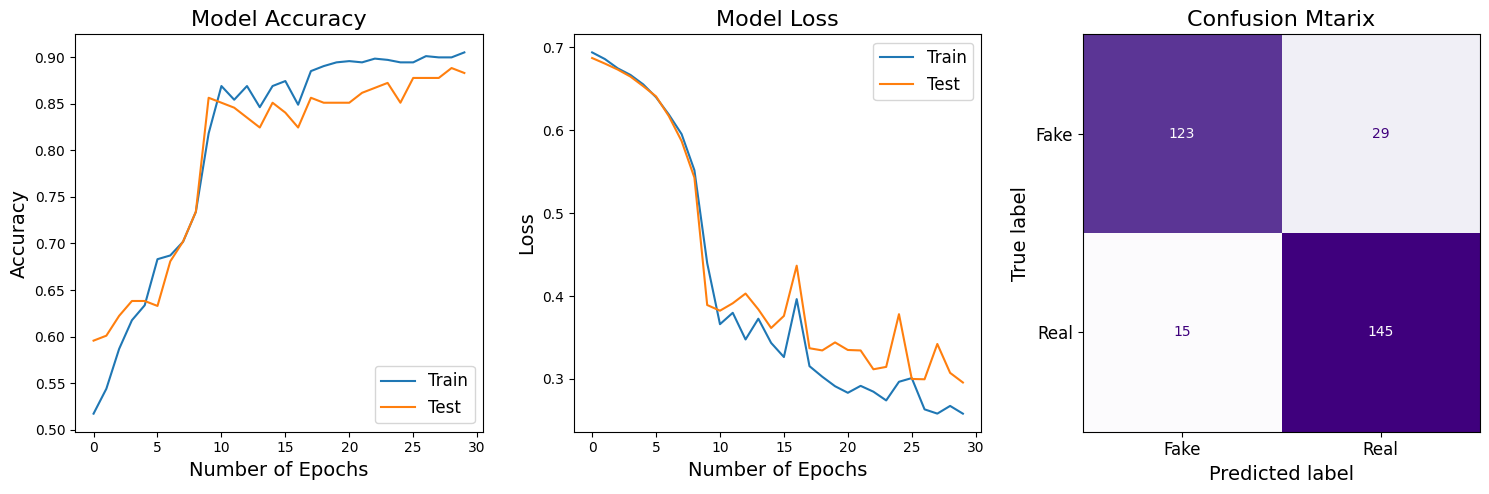

In [5]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns for accuracy, loss, and confusion matrix

# Plot accuracy
axs[0].plot(history.history["accuracy"], label="Train")
axs[0].plot(history.history["val_accuracy"], label="Test")
axs[0].set_ylabel("Accuracy",fontsize=14)
axs[0].set_xlabel("Number of Epochs",fontsize=14)
axs[0].legend(loc="lower right",fontsize=12)
axs[0].set_title("Model Accuracy", fontsize=16)

# Plot loss
axs[1].plot(history.history["loss"], label="Train")
axs[1].plot(history.history["val_loss"], label="Test")
axs[1].set_ylabel("Loss", fontsize=14)
axs[1].set_xlabel("Number of Epochs",fontsize=14)
axs[1].legend(loc="upper right", fontsize=12)
axs[1].set_title("Model Loss", fontsize=16)

# Plot confusion matrix
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)
loss = model.evaluate(X_train, y_train)
cf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['Fake', 'Real'])
disp.plot(ax=axs[2], cmap='Purples')
disp.ax_.set_title('Confusion Mtarix', fontsize=16, fontweight='medium')
disp.im_.colorbar.remove()
disp.ax_.set_xlabel('Predicted label', fontsize=14)
disp.ax_.set_ylabel('True label', fontsize=14)
disp.ax_.set_xticklabels(['Fake', 'Real'], fontsize=12)
disp.ax_.set_yticklabels(['Fake', 'Real'], fontsize=12)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [6]:
model.save("/kaggle/working/audio_lstm.h5")

In [7]:
SAMPLE_RATE = 22050

In [8]:
from tensorflow.keras.models import load_model

*******************************************************************************************************

In [9]:
def predict_genre(model, audio_file_path, genre_mapping):

    # Load audio file
    signal, sample_rate = librosa.load(audio_file_path, sr=22050)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T

    # Resize MFCC to the appropriate size
    mfcc = np.resize(mfcc, (130, 13, 1))

    # Reshape MFCC to the appropriate size
    mfcc = mfcc[np.newaxis, ...]


    # Predict using the model
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction, axis=1)

    # Map predicted index to genre label
    genre_label = genre_mapping[predicted_index[0]]
    print("Raw prediction:", prediction)

    return genre_label

# Load your trained model
model_path = "/kaggle/working/audio_lstm.h5"
model = load_model(model_path)

# Path to the audio file you want to predict
audio_file_path = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1265032.flac" # spoof 
audio_file_path2 = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1056709.flac" # spoof
audio_file_path3 = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1341447.flac" # bonafide
audio_file_path4 = "/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1272637.flac" # bonafide


# Genre mapping (update this according to your dataset)
genre_mapping = {0: "spoof", 1: "bonafide"}

# Make the prediction
predicted_genre = predict_genre(model, audio_file_path, genre_mapping)
print("Predicted genre:", predicted_genre)
predicted_genre = predict_genre(model, audio_file_path2, genre_mapping)
print("Predicted genre:", predicted_genre)
predicted_genre = predict_genre(model, audio_file_path3, genre_mapping)
print("Predicted genre:", predicted_genre)
predicted_genre = predict_genre(model, audio_file_path4, genre_mapping)
print("Predicted genre:", predicted_genre)


1/1 [==============================] - 1s 750ms/step
Raw prediction: [[0.988751   0.01124895]]
Predicted genre: spoof
1/1 [==============================] - 0s 52ms/step
Raw prediction: [[0.98138154 0.01861846]]
Predicted genre: spoof
1/1 [==============================] - 0s 49ms/step
Raw prediction: [[0.15676543 0.8432346 ]]
Predicted genre: bonafide
1/1 [==============================] - 0s 50ms/step
Raw prediction: [[0.10014395 0.8998561 ]]
Predicted genre: bonafide
